# Clustering and Segmentation New York City Neighborhoods on Air Quality

Importing Required Libraries

In [1]:
#!pip3 install numpy
import numpy as np
#!pip3 install pandas
import pandas as pd

#!pip3 install simplejson==3.16.0
import simplejson as json # library to handle JSON files

# convert an address into latitude and longitude values
#!pip3 install geopandas
#!pip3 install geopy
from geopy.geocoders import Nominatim 

# library to handle requests
#!pip3 install requests
import requests
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
#!pip3 install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
#!pip3 install sklearn
from sklearn.cluster import KMeans

# map rendering library
#!pip3 install folium==0.5.0
import folium

print ("Imported all libraries.")

Imported all libraries.


## Environment and Health Data 

From the Environment and Health Data Portal by the City of New York, a data set containing extensive environment and population health data can be requested and downloaded as a csv file. (http://a816-dohbesp.nyc.gov/IndicatorPublic/)

From the Data Portal the following categories of data we requested: Ozone (O3), Fine Particulate Matter (PM2.5), Asthma Hospitalizations of different age groups.

Loading the data from the csv file:

In [2]:
body = "Data.csv"

In [3]:
raw_data = pd.read_csv(body)
raw_data.head()

,Unique Id,indicator_id,geo_type_id,measurement_type_id,internal_id,subtopic_id,name,Measure,geo_type_name,description,geo_entity_id,geo_entity_name,year_description,data_value,message
0,25656,155.0,1.0,1.0,84.0,11.0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,1998,169.8,NaN
1,25657,155.0,1.0,1.0,84.0,11.0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,1999,202.8,NaN
2,25658,155.0,1.0,1.0,84.0,11.0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2000,166.6,NaN
3,25659,155.0,1.0,1.0,84.0,11.0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2001,173.4,NaN
4,25661,155.0,1.0,1.0,84.0,11.0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2003,212.4,NaN


### Cleaning the Data

This dataframe has lost of information we dont need so it needs to be cleaned up. 

In [4]:
#raw_data.shape

Drop some the id columns as the neighborhood/borough information is sufficent for the purpose of this project.

Also dropping message column, which indicates in few cells "Estimate is based on small numbers so should be interpreted with caution".

In [5]:
raw_data.drop(columns=['Unique Id', 'indicator_id','geo_type_id','measurement_type_id','internal_id','subtopic_id', 'message'], inplace=True)
raw_data.head()

,name,Measure,geo_type_name,description,geo_entity_id,geo_entity_name,year_description,data_value
0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,1998,169.8
1,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,1999,202.8
2,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2000,166.6
3,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2001,173.4
4,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,Borough,1.0,Bronx,2003,212.4


In [6]:
raw_data.shape

(18100, 8)

geo_type_name and description colunms contain the same information so geo_type_name can be dropped.

In [7]:
#Dropping geo_type_name column
raw_data.drop(columns=['geo_type_name'], inplace=True)

Simplifying column names

In [8]:
raw_data.rename(columns={'geo_entity_id': 'entity_id', 'geo_entity_name': 'entity_name', 'year_description': 'year', 'data_value': 'value'}, inplace = True)

Checking to see if any rows have invlaid values ('NaN')

In [9]:
nan_values = raw_data.isnull().values.any()

#if there are rows with NaN values, they are dropped here
if nan_values == True:
    raw_data = raw_data.dropna()
    print('Dropped rows with NaN.')
    print(raw_data.shape)
else:
    print('There were no rows with NaN.')
    print(raw_data.shape)

Dropped rows with NaN.
(18030, 7)


The entity_id column contains id values of Boroughs and Neighborhoods, and should be integers.

In [10]:
#Converting geo_entity_id from floats to integers
raw_data['entity_id'] = raw_data['entity_id'].astype(int)
raw_data.head()

,name,Measure,description,entity_id,entity_name,year,value
0,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,1,Bronx,1998,169.8
1,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,1,Bronx,1999,202.8
2,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,1,Bronx,2000,166.6
3,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,1,Bronx,2001,173.4
4,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Estimated Annual Rate,Borough,1,Bronx,2003,212.4


Here you can see the specific categories that was requested from the Data Portal and imported with csv

In [11]:
raw_data['name'].unique()

array(['Asthma Hospitalizations (Children 0 to 4 Yrs Old)',
       'Asthma Hospitalizations (Children 5 to 17 Yrs Old)',
       'Asthma Hospitalizations (Adults)',
       'Fine Particulate Matter (PM2.5)', 'Ozone (O3)'], dtype=object)

In the "Measure" column the data value type of each row is listed.

In [12]:
raw_data['Measure'].unique()

array(['Estimated Annual Rate', 'Number', 'Age-Adjusted Rate', 'Mean',
       '10th Percentile', '90th Percentile'], dtype=object)

For this analysis focus on values of Number and Mean. So drop rows that indicate Estimated Annual Rate, Age-Adjusted Rate, 10th Percentile, or 90th Percentile.

In [13]:
#Dropping any rows that are Estimated Annual Rate, Age-Adjusted Rate, 10th Percentile, or 90th Percentile
raw_data = raw_data[~raw_data['Measure'].isin(['Estimated Annual Rate'])]
raw_data = raw_data[~raw_data['Measure'].isin(['Age-Adjusted Rate'])]
raw_data = raw_data[~raw_data['Measure'].isin(['10th Percentile'])]
raw_data = raw_data[~raw_data['Measure'].isin(['90th Percentile'])]

#Checking to see if specified rows were dropped
raw_data['Measure'].unique()

array(['Number', 'Mean'], dtype=object)

For unformity Neighborhood (UHF 42) will be used to distinguish the neighborhood data. So rows with Neighborhood (UHF 34) and Neighborhood (Community District) as description are dropped.

In [14]:
#Dropping rows with Neighborhood (UHF 34) or Neighborhood (Community District)
raw_data = raw_data[~raw_data['description'].isin(['Neighborhood (UHF 34)'])]
raw_data = raw_data[~raw_data['description'].isin(['Neighborhood (Community District)'])]
#Checking to see if specified rows were dropped
raw_data['description'].unique()

array(['Borough', 'Neighborhood (UHF 42)', 'Citywide'], dtype=object)

In [15]:
raw_data.shape

(3221, 7)

#### Creating uniform data sets

Seperating data to catigories to help with further filtering required before analysis.

In [16]:
data_ozone = raw_data.loc[raw_data['name'] == 'Ozone (O3)'].copy()
data_finePM25 = raw_data.loc[raw_data['name'] == 'Fine Particulate Matter (PM2.5)'].copy()
data_AH_C04 = raw_data.loc[raw_data['name'] == 'Asthma Hospitalizations (Children 0 to 4 Yrs Old)'].copy()
data_AH_C517 = raw_data.loc[raw_data['name'] == 'Asthma Hospitalizations (Children 5 to 17 Yrs Old)'].copy()
data_AH_ADULT = raw_data.loc[raw_data['name'] == 'Asthma Hospitalizations (Adults)'].copy()

Taking a quick look at each of the new dataframes

In [17]:
#only ozone data
data_ozone.head()

,name,Measure,description,entity_id,entity_name,year,value
14289,Ozone (O3),Mean,Borough,1,Bronx,Summer 2009,25.30
14290,Ozone (O3),Mean,Borough,1,Bronx,Summer 2010,33.16
14291,Ozone (O3),Mean,Borough,1,Bronx,Summer 2011,32.91
14292,Ozone (O3),Mean,Borough,1,Bronx,Summer 2012,34.61
14293,Ozone (O3),Mean,Borough,1,Bronx,Summer 2014,31.15


In [18]:
#only fine particulate matter data
data_finePM25.head()

,name,Measure,description,entity_id,entity_name,year,value
3714,Fine Particulate Matter (PM2.5),Mean,Borough,1,Bronx,Winter 2013-14,12.50
3715,Fine Particulate Matter (PM2.5),Mean,Borough,2,Brooklyn,Winter 2013-14,11.86
3716,Fine Particulate Matter (PM2.5),Mean,Borough,3,Manhattan,Winter 2013-14,14.13
3717,Fine Particulate Matter (PM2.5),Mean,Borough,4,Queens,Winter 2013-14,11.23
3718,Fine Particulate Matter (PM2.5),Mean,Borough,5,Staten Island,Winter 2013-14,11.78


In [19]:
#only Asthma Hospitalizations (Children 0 to 4 Yrs Old) data
data_AH_C04.head()

,name,Measure,description,entity_id,entity_name,year,value
75,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Number,Borough,1,Bronx,1998,1845.0
76,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Number,Borough,2,Brooklyn,1998,1855.0
77,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Number,Borough,3,Manhattan,1998,957.0
78,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Number,Borough,4,Queens,1998,1116.0
79,Asthma Hospitalizations (Children 0 to 4 Yrs Old),Number,Borough,5,Staten Island,1998,154.0


In [20]:
#only Asthma Hospitalizations (Children 5 to 17 Yrs Old) data
data_AH_C517.head()

,name,Measure,description,entity_id,entity_name,year,value
1490,Asthma Hospitalizations (Children 5 to 17 Yrs ...,Number,Borough,1,Bronx,2005,1594.0
1491,Asthma Hospitalizations (Children 5 to 17 Yrs ...,Number,Borough,1,Bronx,2006,1542.0
1492,Asthma Hospitalizations (Children 5 to 17 Yrs ...,Number,Borough,1,Bronx,2007,1476.0
1493,Asthma Hospitalizations (Children 5 to 17 Yrs ...,Number,Borough,1,Bronx,2008,1455.0
1494,Asthma Hospitalizations (Children 5 to 17 Yrs ...,Number,Borough,1,Bronx,2010,1311.0


In [21]:
# only Asthma Hospitalizations (Adults) data
data_AH_ADULT.head()

,name,Measure,description,entity_id,entity_name,year,value
2450,Asthma Hospitalizations (Adults),Number,Borough,1,Bronx,2005,5130.0
2451,Asthma Hospitalizations (Adults),Number,Borough,1,Bronx,2006,5357.0
2452,Asthma Hospitalizations (Adults),Number,Borough,1,Bronx,2007,5579.0
2453,Asthma Hospitalizations (Adults),Number,Borough,1,Bronx,2008,5941.0
2454,Asthma Hospitalizations (Adults),Number,Borough,1,Bronx,2010,5641.0


Comparing data types of each dataframe

In [22]:
print ('Ozone')
print ('-----------------------------------')
print('Shape: ', data_ozone.shape)
print('Measure: ', data_ozone['Measure'].unique())
print('description: ', data_ozone['description'].unique())
print('year: ', data_ozone['year'].unique())
print('\n')

print ('Fine Particulate Matter (PM2.5)')
print ('-----------------------------------')
print('Shape: ', data_finePM25.shape)
print('Measure: ', data_finePM25['Measure'].unique())
print('description: ', data_finePM25['description'].unique())
print('year: ', data_finePM25['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Children 0 to 4 Yrs Old)')
print ('-----------------------------------')
print('Shape: ', data_AH_C04.shape)
print('Measure: ', data_AH_C04['Measure'].unique())
print('description: ', data_AH_C04['description'].unique())
print('year: ', data_AH_C04['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Children 5 to 17 Yrs Old)')
print ('-----------------------------------')
print('Shape: ', data_AH_C517.shape)
print('Measure: ', data_AH_C517['Measure'].unique())
print('description: ', data_AH_C517['description'].unique())
print('year: ', data_AH_C517['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Adults)')
print ('-----------------------------------')
print('Shape: ', data_AH_ADULT.shape)
print('Measure: ', data_AH_ADULT['Measure'].unique())
print('description: ', data_AH_ADULT['description'].unique())
print('year: ', data_AH_ADULT['year'].unique())
print('\n')

Ozone
-----------------------------------
Shape:  (432, 7)
Measure:  ['Mean']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['Summer 2009' 'Summer 2010' 'Summer 2011' 'Summer 2012' 'Summer 2014'
 'Summer 2015' 'Summer 2016' 'Summer 2018' 'Summer 2019']


Fine Particulate Matter (PM2.5)
-----------------------------------
Shape:  (1200, 7)
Measure:  ['Mean']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['Winter 2013-14' 'Annual Average 2014' 'Annual Average 2015'
 'Summer 2015' 'Winter 2015-16' 'Summer 2016' 'Annual Average 2016'
 'Summer 2017' 'Winter 2016-17' 'Annual Average 2018' 'Winter 2017-18'
 'Annual Average 2019' 'Summer 2019' 'Winter 2008-09' 'Winter 2009-10'
 'Winter 2011-12' 'Winter 2012-13' 'Summer 2009' 'Summer 2011'
 'Summer 2012' 'Summer 2013' 'Annual Average 2009' 'Annual Average 2010'
 'Annual Average 2011' 'Annual Average 2012']


Asthma Hospitalizations (Children 0 to 4 Yrs Old)
-----------------------------------
Shape:  

For the Ozone dataframe, the year column contains mean ozone readings taken during the Summer of that year. For uniformity the word summer will be dropped and only the year will be displayed.

In [23]:
for index, row in data_ozone.iterrows():
    year_value = row['year']
    split_here = year_value.split(" ")
    data_ozone.at[index, 'year'] = split_here[1]
    
data_ozone.head()

,name,Measure,description,entity_id,entity_name,year,value
14289,Ozone (O3),Mean,Borough,1,Bronx,2009,25.30
14290,Ozone (O3),Mean,Borough,1,Bronx,2010,33.16
14291,Ozone (O3),Mean,Borough,1,Bronx,2011,32.91
14292,Ozone (O3),Mean,Borough,1,Bronx,2012,34.61
14293,Ozone (O3),Mean,Borough,1,Bronx,2014,31.15


For the Fine Particulate Matter (PM2.5) dataframe, the year column contains multiple Fine Particulate Matter values for each year. For uniformity on the Annual Average values will be used and the words Annual Average will be dropped and only the year will be displyed.

In [24]:
for index, row in data_finePM25.iterrows():
    year_value_again = row['year']
    if "Annual" not in year_value_again:
        data_finePM25.drop(index, inplace=True)
    else: 
        split_here_again = year_value_again.split(" ")
        data_finePM25.at[index, 'year'] = split_here_again[2]
        
data_finePM25.head()

,name,Measure,description,entity_id,entity_name,year,value
3719,Fine Particulate Matter (PM2.5),Mean,Borough,1,Bronx,2014,9.27
3720,Fine Particulate Matter (PM2.5),Mean,Borough,2,Brooklyn,2014,9.09
3721,Fine Particulate Matter (PM2.5),Mean,Borough,3,Manhattan,2014,10.85
3722,Fine Particulate Matter (PM2.5),Mean,Borough,4,Queens,2014,8.60
3723,Fine Particulate Matter (PM2.5),Mean,Borough,5,Staten Island,2014,8.41


Looking at the data types of each dataframe again.

In [25]:
print ('Ozone')
print ('-----------------------------------')
print('Shape: ', data_ozone.shape)
print('Measure: ', data_ozone['Measure'].unique())
print('description: ', data_ozone['description'].unique())
print('year: ', data_ozone['year'].unique())
print('\n')

print ('Fine Particulate Matter (PM2.5)')
print ('-----------------------------------')
print('Shape: ', data_finePM25.shape)
print('Measure: ', data_finePM25['Measure'].unique())
print('description: ', data_finePM25['description'].unique())
print('year: ', data_finePM25['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Children 0 to 4 Yrs Old)')
print ('-----------------------------------')
print('Shape: ', data_AH_C04.shape)
print('Measure: ', data_AH_C04['Measure'].unique())
print('description: ', data_AH_C04['description'].unique())
print('year: ', data_AH_C04['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Children 5 to 17 Yrs Old)')
print ('-----------------------------------')
print('Shape: ', data_AH_C517.shape)
print('Measure: ', data_AH_C517['Measure'].unique())
print('description: ', data_AH_C517['description'].unique())
print('year: ', data_AH_C517['year'].unique())
print('\n')

print ('Asthma Hospitalizations (Adults)')
print ('-----------------------------------')
print('Shape: ', data_AH_ADULT.shape)
print('Measure: ', data_AH_ADULT['Measure'].unique())
print('description: ', data_AH_ADULT['description'].unique())
print('year: ', data_AH_ADULT['year'].unique())
print('\n')

Ozone
-----------------------------------
Shape:  (432, 7)
Measure:  ['Mean']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['2009' '2010' '2011' '2012' '2014' '2015' '2016' '2018' '2019']


Fine Particulate Matter (PM2.5)
-----------------------------------
Shape:  (432, 7)
Measure:  ['Mean']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['2014' '2015' '2016' '2018' '2019' '2009' '2010' '2011' '2012']


Asthma Hospitalizations (Children 0 to 4 Yrs Old)
-----------------------------------
Shape:  (716, 7)
Measure:  ['Number']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['1998' '1999' '2000' '2001' '2003' '2004' '2005' '2007' '2008' '2009'
 '2011' '2012' '2013' '2016' '2015']


Asthma Hospitalizations (Children 5 to 17 Yrs Old)
-----------------------------------
Shape:  (442, 7)
Measure:  ['Number']
description:  ['Borough' 'Neighborhood (UHF 42)' 'Citywide']
year:  ['2005' '2006' '2007' '2008' '2010' '2011' '2012' '20

Now the dataframes are uniform in their structure.

## Location Data

Location Data for the neighborhoods must be retrieved.

In [26]:
column_names = ['Neighborhood', 'Latitude', 'Longitude']
location_data = pd.DataFrame(columns = column_names)

Using one of the previous tables to get the names of the neighborhoods

In [27]:
#This gives a list of all the neighborhood names which can be added to the location_data dataframe
names = raw_data.loc[raw_data['description'] == 'Neighborhood (UHF 42)']
list = names['entity_name'].unique()

In [28]:
location_data['Neighborhood'] = np.array(list)
location_data['Latitude'] = location_data['Latitude'].fillna(0.0)
location_data['Longitude'] = location_data['Longitude'].fillna(0.0)
location_data.head()

,Neighborhood,Latitude,Longitude
0,Kingsbridge - Riverdale,0.0,0.0
1,Northeast Bronx,0.0,0.0
2,Fordham - Bronx Pk,0.0,0.0
3,Pelham - Throgs Neck,0.0,0.0
4,Crotona -Tremont,0.0,0.0


Now use Geocode to get Latitude and Logitude for each neighborhood.

In [29]:
def need_address(address):

    return find_exact

In [30]:
for index, row in location_data.iterrows():
    the_name = str(row['Neighborhood'])
    the_end = ', New York, USA'
    address = the_name + the_end
    #print(address)
    
    find = Nominatim(user_agent='myGeocoder')
    find_exact = find.geocode(address, timeout=10000)
    
    #Because of format of the neighborhood names, conditions have to be set incase the data comes back as None type
    if find_exact is None and '-' in the_name:
        split_this = the_name.split("-")
        address_again = split_this[0] + the_end

        find_this = Nominatim(user_agent='myGeocoder1')
        find_this_exact = find_this.geocode(address_again, timeout=10000)
        
        find_exact = find_this_exact
        
        if find_this_exact is None:
            address_again_too = split_this[1] + the_end

            find_this_once = Nominatim(user_agent='myGeocoder1')
            find_this_once_exact = find_this_once.geocode(address_again_too, timeout=10000)
            
            find_exact = find_this_once_exact
        else:
            pass
            
    elif find_exact is None and ' ' in the_name:
        split_this = the_name.split(" ")
        #print(split_this)
        address_again = split_this[1] + the_end
            
        find_this = Nominatim(user_agent='myGeocoder1')
        find_this_exact = find_this.geocode(address_again, timeout=10000)
        
        find_exact = find_this_exact
        
    else:
        pass
        
        
    location_data.at[index,'Latitude'] = find_exact.latitude
    location_data.at[index,'Longitude'] = find_exact.longitude

location_data

,Neighborhood,Latitude,Longitude
0,Kingsbridge - Riverdale,40.878705,-73.905141
1,Northeast Bronx,40.846651,-73.878594
2,Fordham - Bronx Pk,40.859267,-73.898469
3,Pelham - Throgs Neck,40.909821,-73.807911
4,Crotona -Tremont,40.848371,-73.882852
5,High Bridge - Morrisania,40.836767,-73.926804
6,Hunts Point - Mott Haven,40.812601,-73.884025
7,Greenpoint,40.723713,-73.950971
8,Downtown - Heights - Slope,43.047874,-76.149929
9,Bedford Stuyvesant - Crown Heights,40.683436,-73.941249


In [31]:
c_address = 'New York City, New York, USA'

geolocator = Nominatim(user_agent="myGeocoder")
location = geolocator.geocode(c_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [32]:
# create a map
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

# addding neighborhood markers to the map
for lat, lng, neighborhood in zip(location_data['Latitude'], location_data['Longitude'], location_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

## Foursquare data

Now that we have Latitude and Logitude for each neighborhood we can use Foursquare to extract neighborhood details.

In [33]:
# @hidden_cell
CLIENT_ID = 'LQ4DTKOFGZU0XD2VYTSR0BAELFSTMAPP1JJDE424CIR5BCSE' #Foursquare ID
CLIENT_SECRET = 'LCQPLABT1DQ2HPMONBNOOCA1T3PX0DIUE5AZLXLYODJYFSQG' #Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Defining a function to get information from Foursquare about all the neighborhoods.

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the function on the location_data table

In [35]:
nyc_venues = getNearbyVenues(names = location_data['Neighborhood'], latitudes = location_data['Latitude'], 
                                   longitudes = location_data['Longitude'])

Kingsbridge - Riverdale
Northeast Bronx
Fordham - Bronx Pk
Pelham - Throgs Neck
Crotona -Tremont
High Bridge - Morrisania
Hunts Point - Mott Haven
Greenpoint
Downtown - Heights - Slope
Bedford Stuyvesant - Crown Heights
East New York
Sunset Park
Borough Park
East Flatbush - Flatbush
Canarsie - Flatlands
Bensonhurst - Bay Ridge
Coney Island - Sheepshead Bay
Williamsburg - Bushwick
Washington Heights
Central Harlem - Morningside Heights
East Harlem
Upper West Side
Upper East Side
Chelsea - Clinton
Gramercy Park - Murray Hill
Greenwich Village - SoHo
Union Square - Lower East Side
Lower Manhattan
Long Island City - Astoria
West Queens
Flushing - Clearview
Bayside - Little Neck
Ridgewood - Forest Hills
Fresh Meadows
Southwest Queens
Jamaica
Southeast Queens
Rockaways
Port Richmond
Stapleton - St. George
Willowbrook
South Beach - Tottenville


In [36]:
print(nyc_venues.shape)
nyc_venues.head()

(1792, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kingsbridge - Riverdale,40.878705,-73.905141,Sam's Pizza,40.879435,-73.905859,Pizza Place
1,Kingsbridge - Riverdale,40.878705,-73.905141,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Kingsbridge - Riverdale,40.878705,-73.905141,The Bronx Public,40.878377,-73.903481,Pub
3,Kingsbridge - Riverdale,40.878705,-73.905141,El Malecon,40.879338,-73.904457,Caribbean Restaurant
4,Kingsbridge - Riverdale,40.878705,-73.905141,Estrellita Poblana V,40.879687,-73.906257,Mexican Restaurant


In [37]:
nyc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayside - Little Neck,15,15,15,15,15,15
Bedford Stuyvesant - Crown Heights,58,58,58,58,58,58
Bensonhurst - Bay Ridge,61,61,61,61,61,61
Borough Park,25,25,25,25,25,25
Canarsie - Flatlands,24,24,24,24,24,24
Central Harlem - Morningside Heights,51,51,51,51,51,51
Chelsea - Clinton,13,13,13,13,13,13
Coney Island - Sheepshead Bay,3,3,3,3,3,3
Crotona -Tremont,28,28,28,28,28,28


In [38]:
#How many unique catigories
print('There are {} unique categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 271 unique categories.


We can use **One Hot Encoding** to make the data easier to work with.

In [39]:
# one hot encoding
nyc_venues_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhoods = nyc_venues['Neighborhood'] 
nyc_venues_onehot.insert (0, "Neighborhood", neighborhoods)

nyc_venues_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Kingsbridge - Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kingsbridge - Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Kingsbridge - Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kingsbridge - Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kingsbridge - Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now with all this data can be manuvered to allow for better analysis during clustering

 - First grouped the data by neighborhood and found the mean frequency of each type of venue
 - Created a new dataframe to display the top 10 venues by neighborhood

In [40]:
nyc_grouped = nyc_venues_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bayside - Little Neck,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bedford Stuyvesant - Crown Heights,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.0,0.0
2,Bensonhurst - Bay Ridge,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Borough Park,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Canarsie - Flatlands,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


This function sorts the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayside - Little Neck,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,Bedford Stuyvesant - Crown Heights,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,Bensonhurst - Bay Ridge,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,Borough Park,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
4,Canarsie - Flatlands,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School


Now we have air quality data, health data, and location data.

## K Means Analysis

We want to cluster neighborhoods based on similarity based on both location data and air quality data. For this we use the most recent Ozone and Fine Particulate Matter data, which would be 2019. The Ozone and Fine Particulate Matter nieghborhood readings should be combined with the venue data. 

Extracting 2019 data from Ozone and Fine Particulate Matter tables.

In [43]:
PM25_2019 = data_finePM25.loc[data_finePM25['description'] == 'Neighborhood (UHF 42)'].copy()
PM25_2019 = PM25_2019.loc[PM25_2019['year'] == '2019']
#deleting al the unnecessary columns 
PM25_2019.drop(columns=['name','Measure','description', 'entity_id','year'], inplace=True)
PM25_2019.head()

,entity_name,value
4845,Kingsbridge - Riverdale,6.71
4847,Northeast Bronx,6.68
4849,Fordham - Bronx Pk,6.70
4851,Pelham - Throgs Neck,6.74
4853,Crotona -Tremont,7.23


In [44]:
Oz_2019 = data_ozone.loc[data_ozone['description'] == 'Neighborhood (UHF 42)'].copy()
Oz_2019 = Oz_2019.loc[Oz_2019['year'] == '2019']
#deleting al the unnecessary columns 
Oz_2019.drop(columns=['name','Measure','description', 'entity_id','year'], inplace=True)
Oz_2019.head()

,entity_name,value
14760,Kingsbridge - Riverdale,28.43
14761,Northeast Bronx,30.34
14762,Fordham - Bronx Pk,29.64
14763,Pelham - Throgs Neck,30.87
14764,Crotona -Tremont,29.06


In [45]:
cluster_data = venues_sorted.copy()
cluster_data.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayside - Little Neck,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,Bedford Stuyvesant - Crown Heights,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,Bensonhurst - Bay Ridge,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,Borough Park,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
4,Canarsie - Flatlands,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School


In [46]:
#adding Ozone and PM 2.5 into the data frame
cluster_data.insert(1, 'Ozone', '')
cluster_data.insert(2, 'PM 2.5', '')
cluster_data.head()

,Neighborhood,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayside - Little Neck,,,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,Bedford Stuyvesant - Crown Heights,,,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,Bensonhurst - Bay Ridge,,,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,Borough Park,,,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
4,Canarsie - Flatlands,,,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School


Interate over each row in the tables to match neighborhood names and add in the ozone and fine particulate matter values.

In [47]:
for index1, row1 in cluster_data.iterrows():
    neighborhood = row1['Neighborhood']
    #Iterate over each row in Toronto Table
    for index2, row2 in Oz_2019.iterrows():
        oz = row2['entity_name']
        
        #If the neighborhood names are the same in the rows, then the Ozone value is transfered to the proper row in the cluster data table.
        if neighborhood == oz :            
            cluster_data.at[index1,'Ozone'] = row2['value']
        else:
            pass
        
    for index3, row3 in PM25_2019.iterrows():
        pm = row3['entity_name']
        
        #If the neighborhood names are the same in the rows, then the value is transfered to the proper row in the cluster data table.
        if neighborhood == pm :            
            cluster_data.at[index1,'PM 2.5'] = row3['value']
        else:
            pass

In [48]:
cluster_data.head()

,Neighborhood,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayside - Little Neck,31.68,6.21,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,Bedford Stuyvesant - Crown Heights,30.46,6.61,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,Bensonhurst - Bay Ridge,30.83,6.21,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,Borough Park,30.62,6.32,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
4,Canarsie - Flatlands,34.05,6.15,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School


In [49]:
#clustering data set
to_cluster_with = nyc_grouped.copy()
to_cluster_with.insert(1, 'Ozone', '')
to_cluster_with.insert(2, 'PM 2.5', '')


for index1, row1 in to_cluster_with.iterrows():
    neighborhood = row1['Neighborhood']
    #Iterate over each row in Toronto Table
    for index2, row2 in Oz_2019.iterrows():
        oz = row2['entity_name']
        
        #If the neighborhood names are the same in the rows, then the Ozone value is transfered to the proper row in the cluster data table.
        if neighborhood == oz :            
            to_cluster_with.at[index1,'Ozone'] = row2['value']
        else:
            pass
        
    for index3, row3 in PM25_2019.iterrows():
        pm = row3['entity_name']
        
        #If the neighborhood names are the same in the rows, then the value is transfered to the proper row in the cluster data table.
        if neighborhood == pm :            
            to_cluster_with.at[index1,'PM 2.5'] = row3['value']
        else:
            pass

In [50]:
to_cluster_with.head()

,Neighborhood,Ozone,PM 2.5,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Arcade,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bayside - Little Neck,31.68,6.21,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bedford Stuyvesant - Crown Heights,30.46,6.61,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,...,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.0,0.0
2,Bensonhurst - Bay Ridge,30.83,6.21,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Borough Park,30.62,6.32,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Canarsie - Flatlands,34.05,6.15,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [51]:
nyc_clustering = to_cluster_with.drop('Neighborhood', 1)

nyc_clustering.head()

,Ozone,PM 2.5,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,31.68,6.21,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,30.46,6.61,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.0,0.0
2,30.83,6.21,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,30.62,6.32,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,34.05,6.15,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


With prelimnary testing of different number of clusters, it was found that 4 clusters was found to provide the most optimal grouping, based on distribution of the data.

In [52]:
# set number of clusters
kclusters = 4

In [53]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:41]

array([3, 3, 3, 3, 1, 2, 0, 1, 2, 2, 3, 2, 1, 3, 3, 3, 0, 2, 0, 2, 2, 1,
       2, 2, 0, 3, 3, 2, 3, 1, 3, 1, 1, 2, 2, 0, 0, 0, 2, 3, 2],
      dtype=int32)

Combining Venue, location, and clustering data together

In [54]:
cluster_data_both = cluster_data.copy()
cluster_data_both.insert(0, 'Cluster Labels', kmeans.labels_)

In [55]:
nyc_merged_both = cluster_data_both.copy()
nyc_merged_both.insert(2, 'Latitude', location_data['Latitude'])
nyc_merged_both.insert(3, 'Longitude', location_data['Longitude'])
nyc_merged_both.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Bayside - Little Neck,40.878705,-73.905141,31.68,6.21,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,3,Bedford Stuyvesant - Crown Heights,40.846651,-73.878594,30.46,6.61,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,3,Bensonhurst - Bay Ridge,40.859267,-73.898469,30.83,6.21,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,3,Borough Park,40.909821,-73.807911,30.62,6.32,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
4,1,Canarsie - Flatlands,40.848371,-73.882852,34.05,6.15,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School


In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged_both['Latitude'], nyc_merged_both['Longitude'], nyc_merged_both['Neighborhood'], nyc_merged_both['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Looking at each cluster to understand distinguishing features.

Cluster 0:

In [57]:
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Latitude,Longitude,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,0,Chelsea - Clinton,40.812601,-73.884025,23.84,10.21,Cosmetics Shop,Gym / Fitness Center,Boxing Gym,Recreation Center,Department Store,Arcade,Discount Store,Clothing Store,Bagel Shop,Bus Station
16,0,Gramercy Park - Murray Hill,44.606171,-74.971586,23.96,10.09,New American Restaurant,American Restaurant,Italian Restaurant,Bar,Café,Spa,Wine Shop,Coffee Shop,Park,Juice Bar
18,0,Greenwich Village - SoHo,41.470226,-74.415175,25.04,9.65,American Restaurant,Yoga Studio,Wine Bar,Italian Restaurant,Coffee Shop,Steakhouse,Massage Studio,Sandwich Place,Ice Cream Shop,Flower Shop
24,0,Lower Manhattan,40.737925,-73.985932,24.72,8.23,Cocktail Bar,Bar,Mexican Restaurant,Sandwich Place,Coffee Shop,Café,Ice Cream Shop,Chinese Restaurant,Boutique,Pizza Place
35,0,Union Square - Lower East Side,40.691485,-73.805677,25.72,8.87,Gym / Fitness Center,Cosmetics Shop,Café,Pizza Place,Yoga Studio,Outdoor Sculpture,Dessert Shop,Mediterranean Restaurant,Salad Place,Japanese Restaurant
36,0,Upper East Side,40.749824,-73.797634,25.88,8,Italian Restaurant,Coffee Shop,Art Museum,Boutique,Cosmetics Shop,Outdoor Sculpture,French Restaurant,Hotel,Clothing Store,American Restaurant
37,0,Upper West Side,40.589375,-73.801568,25.59,7.38,Italian Restaurant,Bar,Café,Pizza Place,Coffee Shop,American Restaurant,Indian Restaurant,Bakery,Wine Bar,Ice Cream Shop


Cluster 1:

In [58]:
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Latitude,Longitude,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,1,Canarsie - Flatlands,40.848371,-73.882852,34.05,6.15,Deli / Bodega,Caribbean Restaurant,Food,Cosmetics Shop,Kids Store,Food Truck,Fruit & Vegetable Store,Mobile Phone Shop,Men's Store,Martial Arts School
7,1,Coney Island - Sheepshead Bay,40.723713,-73.950971,33.33,6.04,Coffee Shop,Restaurant,Construction & Landscaping,Zoo Exhibit,Ethiopian Restaurant,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
12,1,East New York,40.633993,-73.996806,32.61,6.56,Bakery,Fried Chicken Joint,Plaza,Pharmacy,Grocery Store,Bus Station,Farmers Market,Art Gallery,Pizza Place,Fast Food Restaurant
21,1,Jamaica,40.787045,-73.975416,32.83,6.24,Food Truck,Deli / Bodega,Bar,Portuguese Restaurant,Swiss Restaurant,Bus Station,Mobile Phone Shop,Farm,Park,Bakery
29,1,Rockaways,40.651674,-73.779602,37.44,5.59,Surf Spot,Supermarket,Caribbean Restaurant,Beach,Metro Station,Brewery,Bank,Taco Place,Café,BBQ Joint
31,1,Southeast Queens,40.768435,-73.777077,33.42,6.01,Bike Trail,Deli / Bodega,Scenic Lookout,Korean Restaurant,Art Gallery,Bus Station,Sports Club,Fast Food Restaurant,Eye Doctor,Falafel Restaurant
32,1,Southwest Queens,43.250335,-78.647254,33.31,6.19,Greek Restaurant,Pizza Place,Deli / Bodega,Italian Restaurant,Grocery Store,Mexican Restaurant,Wine Shop,Pharmacy,Bar,Sports Bar


Cluster 2:

In [59]:
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,Latitude,Longitude,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,2,Central Harlem - Morningside Heights,40.836767,-73.926804,27.07,7,Italian Restaurant,Café,Coffee Shop,Chinese Restaurant,Park,Mexican Restaurant,Pharmacy,Deli / Bodega,Concert Hall,Optical Shop
8,2,Crotona -Tremont,43.047874,-76.149929,29.06,7.23,Zoo Exhibit,Zoo,Exhibit,Ice Cream Shop,Theme Park,General Travel,Gas Station,Pizza Place,Grocery Store,Garden
9,2,Downtown - Heights - Slope,40.683436,-73.941249,27.61,7.44,Hotel,American Restaurant,Sandwich Place,Restaurant,Bakery,Italian Restaurant,New American Restaurant,Pizza Place,Plaza,Pub
11,2,East Harlem,40.644337,-74.007532,27.51,7.11,Bakery,Mexican Restaurant,Pizza Place,Taco Place,Donut Shop,Street Art,Spanish Restaurant,Liquor Store,Beer Bar,French Restaurant
17,2,Greenpoint,40.714622,-73.953450,27.77,8.56,Pizza Place,Coffee Shop,Yoga Studio,Deli / Bodega,Thrift / Vintage Store,Italian Restaurant,Sushi Restaurant,Bar,Ice Cream Shop,Bagel Shop
19,2,High Bridge - Morrisania,40.810000,-73.962500,28.62,7.14,Bus Station,Pharmacy,Food,Chinese Restaurant,Pizza Place,Playground,Garden,Gym,Baseball Stadium,Park
20,2,Hunts Point - Mott Haven,40.794722,-73.942500,29.58,7.52,Chinese Restaurant,Spanish Restaurant,Bank,Pizza Place,Dessert Shop,BBQ Joint,Farmers Market,Waste Facility,Juice Bar,Mexican Restaurant
22,2,Kingsbridge - Riverdale,40.773702,-73.964120,28.43,6.71,Pizza Place,Mexican Restaurant,Supplement Shop,Supermarket,Discount Store,Spanish Restaurant,Sandwich Place,Donut Shop,Gym,Steakhouse
23,2,Long Island City - Astoria,40.600660,-74.194867,28.36,7.99,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Café,Vietnamese Restaurant,Indie Theater,Japanese Restaurant,Restaurant,Art Gallery,Bar
27,2,Port Richmond,40.718764,-73.990313,27.27,6.34,Bus Stop,Chinese Restaurant,Pizza Place,Pool Hall,Breakfast Spot,Mexican Restaurant,Martial Arts School,Supermarket,Ice Cream Shop,Deli / Bodega


Cluster 3:

In [60]:
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Latitude,Longitude,Ozone,PM 2.5,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Bayside - Little Neck,40.878705,-73.905141,31.68,6.21,Pizza Place,Farmers Market,Chinese Restaurant,Intersection,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Gym,Asian Restaurant
1,3,Bedford Stuyvesant - Crown Heights,40.846651,-73.878594,30.46,6.61,Pizza Place,Coffee Shop,Café,Bar,Restaurant,Fried Chicken Joint,Boutique,Mexican Restaurant,Caribbean Restaurant,Sandwich Place
2,3,Bensonhurst - Bay Ridge,40.859267,-73.898469,30.83,6.21,Chinese Restaurant,Bakery,Cantonese Restaurant,Bank,Mobile Phone Shop,Shoe Store,Pizza Place,Japanese Restaurant,Gourmet Shop,Kids Store
3,3,Borough Park,40.909821,-73.807911,30.62,6.32,Restaurant,Pizza Place,Café,Pharmacy,Fast Food Restaurant,Bank,American Restaurant,Coffee Shop,Candy Store,Hotel
10,3,East Flatbush - Flatbush,40.666770,-73.882358,31.43,6.31,Caribbean Restaurant,Bank,Grocery Store,Bakery,Dog Run,Chinese Restaurant,Pizza Place,Farmers Market,Mobile Phone Shop,Sandwich Place
13,3,Flushing - Clearview,40.653715,-73.930415,31.3,6.61,Korean Restaurant,Pizza Place,Coffee Shop,Karaoke Bar,Cosmetics Shop,Sandwich Place,Mobile Phone Shop,Bath House,Fried Chicken Joint,Bar
14,3,Fordham - Bronx Pk,40.641654,-73.903271,29.64,6.7,Mobile Phone Shop,Spanish Restaurant,Donut Shop,Clothing Store,Bank,Fried Chicken Joint,Shoe Store,Pizza Place,Restaurant,Gym
15,3,Fresh Meadows,40.604977,-73.993406,31.81,6.16,Deli / Bodega,Playground,Automotive Shop,Bubble Tea Shop,South American Restaurant,Basketball Court,Park,Pizza Place,Coffee Shop,Fast Food Restaurant
25,3,Northeast Bronx,40.731980,-73.996566,30.34,6.68,Zoo Exhibit,Zoo,Park,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Exhibit,Souvenir Shop,Garden,Gas Station
26,3,Pelham - Throgs Neck,40.735909,-73.990163,30.87,6.74,American Restaurant,Ice Cream Shop,Italian Restaurant,Cosmetics Shop,Park,Bakery,Bank,Pharmacy,Thai Restaurant,Bar


Look at simple statistics of Ozone and PM 2.5 of each cluster.

Cluster 0:

In [61]:
print ('Cluster 0')
print ('---------------')
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 0].agg({'Ozone': ['min', 'max', 'mean'],'PM 2.5': ['min', 'max', 'mean']})

Cluster 0
---------------


,Ozone,PM 2.5
min,23.840000,7.380000
max,25.880000,10.210000
mean,24.964286,8.918571


Cluster 1:

In [62]:
print ('Cluster 1')
print ('---------------------- ')
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 1].agg({'Ozone': ['min', 'max', 'mean'],'PM 2.5': ['min', 'max', 'mean']})

Cluster 1
---------------------- 


,Ozone,PM 2.5
min,32.610000,5.590000
max,37.440000,6.560000
mean,33.855714,6.111429


Cluster 2:

In [63]:
print ('Cluster 2')
print ('---------------------- ')
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 2].agg({'Ozone': ['min', 'max', 'mean'],'PM 2.5': ['min', 'max', 'mean']})

Cluster 2
---------------------- 


,Ozone,PM 2.5
min,27.070000,5.900
max,29.580000,8.560
mean,28.338667,7.122


Cluster 3:

In [64]:
print ('Cluster 3')
print ('---------------------- ')
nyc_merged_both.loc[nyc_merged_both['Cluster Labels'] == 3].agg({'Ozone': ['min', 'max', 'mean'],'PM 2.5': ['min', 'max', 'mean']})

Cluster 3
---------------------- 


,Ozone,PM 2.5
min,29.640000,5.810000
max,31.810000,7.350000
mean,30.797692,6.482308


## Visulization of Environment and Health Data 

To understand why air quality is an important health factor, the ozone and fine particulate matter data can be compared to asthma hospitaiation data.

First we can look at Overall New York City Data. (Pulling from all the data tables created before)

In [65]:
#Ozone
city_ozone = data_ozone
city_ozone = city_ozone.loc[city_ozone['description'] == 'Citywide']
city_ozone = city_ozone.drop(columns=['name', 'Measure','description','entity_id','entity_name'])
city_ozone.rename(columns={'year': 'Year', 'value': "Ozone"}, inplace = True)

#PM 2.5 data
city_pm25 = data_finePM25
city_pm25 = city_pm25.loc[city_pm25['description'] == 'Citywide']
city_pm25 = city_pm25.drop(columns=['name', 'Measure','description','entity_id','entity_name'])
city_pm25.rename(columns={'year': 'Year', 'value': "PM2.5"}, inplace = True)

#Asthma Hospitalizations (Children 0 to 4 Yrs Old)
city_c04 = data_AH_C04
city_c04 = city_c04.loc[city_c04['description'] == 'Citywide']
city_c04 = city_c04.drop(columns=['name', 'Measure','description','entity_id','entity_name'])
city_c04.rename(columns={'year': 'Year', 'value': "Children 0 to 4"}, inplace = True)

#Asthma Hospitalizations (Children 5 to 17 Yrs Old)
city_c517 = data_AH_C517
city_c517 = city_c517.loc[city_c517['description'] == 'Citywide']
city_c517 = city_c517.drop(columns=['name', 'Measure','description','entity_id','entity_name'])
city_c517.rename(columns={'year': 'Year', 'value': "Children 5 to 17"}, inplace = True)

#Asthma Hospitalizations (Adults)
city_adult = data_AH_ADULT
city_adult = city_adult.loc[city_adult['description'] == 'Citywide']
city_adult = city_adult.drop(columns=['name', 'Measure','description','entity_id','entity_name'])
city_adult.rename(columns={'year': 'Year', 'value': "Adults"}, inplace = True)

#Merging on Year
city_merge = pd.merge(city_ozone, city_pm25, on='Year', how='outer')
city_merge = pd.merge(city_merge, city_c04, on='Year',  how='outer')
city_merge = pd.merge(city_merge, city_c517, on='Year',  how='outer')
city_merge = pd.merge(city_merge, city_adult, on='Year',  how='outer')

#only including years between 2009 - 2019
city_merge = city_merge.loc[city_merge['Year'] > '2008']

#Sort by year
city_merge = city_merge.sort_values(['Year'], ascending=[True])
city_merge = city_merge.reset_index()
city_merge = city_merge.drop(columns=['index'])
city_merge


,Year,Ozone,PM2.5,Children 0 to 4,Children 5 to 17,Adults
0,2009,26.0000,10.4300,5041.0,NaN,NaN
1,2010,33.6800,9.5400,NaN,3563.0,17423.0
2,2011,33.1000,10.1000,4073.0,3652.0,16904.0
3,2012,33.8300,8.9500,4120.0,3947.0,16422.0
4,2013,NaN,NaN,3869.0,NaN,NaN
5,2014,31.3700,8.9300,NaN,4106.0,14603.0
6,2015,31.8377,8.5604,3514.0,3547.0,NaN
7,2016,33.8200,7.4500,3380.0,3373.0,7525.0
8,2018,30.5600,7.0000,NaN,NaN,NaN
9,2019,30.5500,6.6000,NaN,NaN,NaN


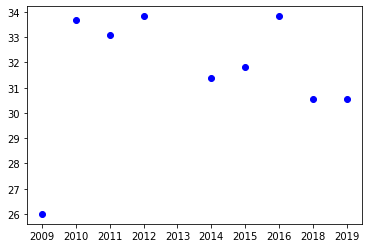

In [66]:
see_ozone = plt.plot(city_merge['Year'], city_merge['Ozone'], 'bo')
see_ozone

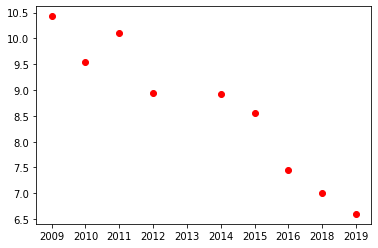

In [67]:
see_pm25 = plt.plot(city_merge['Year'], city_merge['PM2.5'], 'ro')
see_pm25

The Asthma data only contains data from 2009-2016 so filtering that data
Then plotting scatter Plots

In [68]:
city_merge_0916 = city_merge.copy()
city_merge_0916 = city_merge_0916.loc[city_merge_0916['Year'] < '2018']

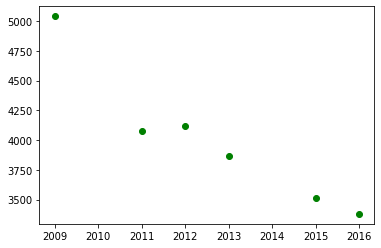

In [69]:
see_c04 = plt.plot(city_merge_0916['Year'], city_merge_0916['Children 0 to 4'], 'go')
see_c04

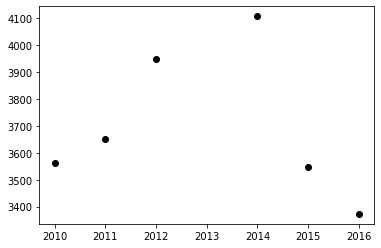

In [70]:
see_c517 = plt.plot(city_merge_0916['Year'], city_merge_0916['Children 5 to 17'], 'ko')
see_c517

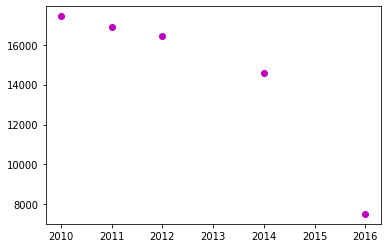

In [71]:
see_adult = plt.plot(city_merge_0916['Year'], city_merge_0916['Adults'], 'mo')
see_adult

Line plots are a better visual to show trends over time

To account for missing values in between data, any missing vlaues were filled.

In [72]:
city_merge_0916['Year_fill'] = city_merge_0916['Year'].ffill()
city_merge_0916['Ozone_fill'] = city_merge_0916['Ozone'].ffill()
city_merge_0916['PM2.5_fill'] = city_merge_0916['PM2.5'].ffill()
city_merge_0916['Adults_fill'] = city_merge_0916['Adults'].ffill()
city_merge_0916['Children 0 to 4_fill'] = city_merge_0916['Children 0 to 4'].ffill()
city_merge_0916['Children 5 to 17_fill'] = city_merge_0916['Children 5 to 17'].ffill()

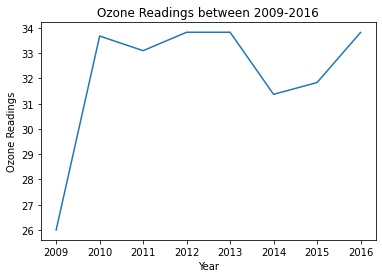

In [73]:
plt.plot(city_merge_0916['Year_fill'], city_merge_0916['Ozone_fill'])
plt.xlabel('Year')
plt.ylabel('Ozone Readings')
plt.title('Ozone Readings between 2009-2016')
plt.show()

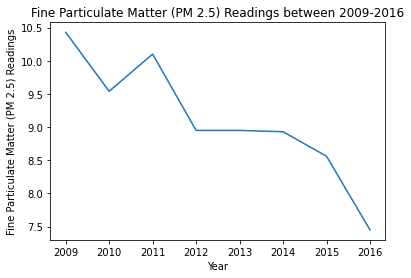

In [74]:
plt.plot(city_merge_0916['Year_fill'], city_merge_0916['PM2.5_fill'])
plt.xlabel('Year')
plt.ylabel('Fine Particulate Matter (PM 2.5) Readings')
plt.title('Fine Particulate Matter (PM 2.5) Readings between 2009-2016')
plt.show()

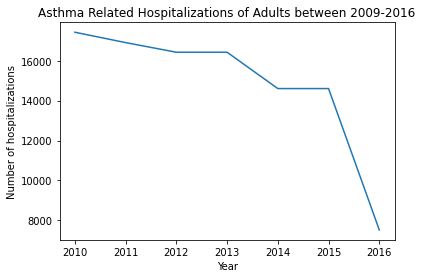

In [75]:
plt.plot(city_merge_0916['Year_fill'], city_merge_0916['Adults_fill'])
plt.xlabel('Year')
plt.ylabel('Number of hospitalizations')
plt.title('Asthma Related Hospitalizations of Adults between 2009-2016')
plt.show()

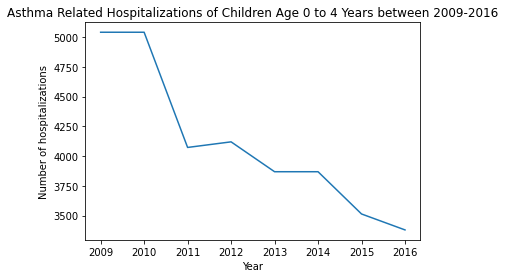

In [76]:
plt.plot(city_merge_0916['Year_fill'], city_merge_0916['Children 0 to 4_fill'])
plt.xlabel('Year')
plt.ylabel('Number of hospitalizations')
plt.title('Asthma Related Hospitalizations of Children Age 0 to 4 Years between 2009-2016')
plt.show()

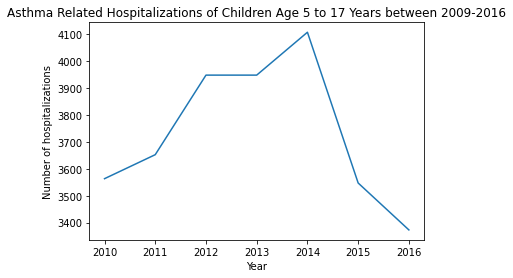

In [77]:
plt.plot(city_merge_0916['Year_fill'], city_merge_0916['Children 5 to 17_fill'])
plt.xlabel('Year')
plt.ylabel('Number of hospitalizations')
plt.title('Asthma Related Hospitalizations of Children Age 5 to 17 Years between 2009-2016')
plt.show()